# Explore Distributed Corpus

The notebook showcases functionalities for exploring the "distributed ngrams", which is a bit slower but doesn't require as much memory compared to loading the complete word count matrix. The querying is parallellized.

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
from tools.ngram_exploration import *
import seaborn as sns
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import jensenshannon
from tqdm import tqdm_notebook
sns.set()

# "Deep" Query of Newspaper Collection

In this scenario we obtain finegrained results at level of newspaper-month with the corresponding metadata.

The query_dict allows you to fire a bunch of queries at the same time. The keys are indices/names for each query, the values are a list of terms.

In [7]:
query_dict =  {1:['machine'],
               2:['train','railway'],
               3:['accident','accidents'],
               4:['machine','machines'],
               5:['snow','freezing','frost']}

In [12]:
# initialize the corpus
corpus = DistributedCorpus('../sparse_ngrams/',n_cores=12)

In [13]:
%time res = corpus.query(query_dict) # query the corpus
df = pd.concat(res); df.head() # concatenate the results into one dataframe

CPU times: user 1.01 s, sys: 145 ms, total: 1.16 s
Wall time: 1min 13s


## Create and plot time lines

In [2]:
#help(DistributedCorpus)

In [ ]:
df.groupby('year')['totals'].sum().loc[1780:1920].plot(figsize=(15,5))

In [ ]:
df.groupby('year')['totals'].sum().apply(np.log10).loc[1780:1920].plot(figsize=(15,5))

In [ ]:
(df.groupby('month')['counts_4'].sum() / df.groupby('month')['totals'].sum())["1780-01":"1920-01"].plot(figsize=(15,5))

In [ ]:
(df.groupby('year')['counts_4'].sum() / df.groupby('year')['totals'].sum()).loc[1780:1920].plot(figsize=(15,5))


# "Light" Query and Divergence Heatmap

In [7]:
corpus = DistributedCorpus('../sparse_ngrams/',n_cores=12))

In [8]:
%time counts,ts = corpus.counts_by_timestep('year')


CPU times: user 4min 44s, sys: 1min 12s, total: 5min 57s
Wall time: 37min 33s


In [10]:
matrix_norm = (counts.T / counts.sum(axis=1)).T

## Timeline

In [ ]:
kwList = ['cycling','cycles']
%time pd.Series(matrix_norm[:,[corpus.vocab_mapping[kw] for kw in kwList]].sum(axis=1),index=ts).plot()

## Heatmap

In [11]:
pairdist = pairwise_distances(matrix_norm,metric=jensenshannon)

In [12]:
#labels = sorted(counts_norm.keys())
df_pairdist = pd.DataFrame(pairdist,columns=ts,index=ts)

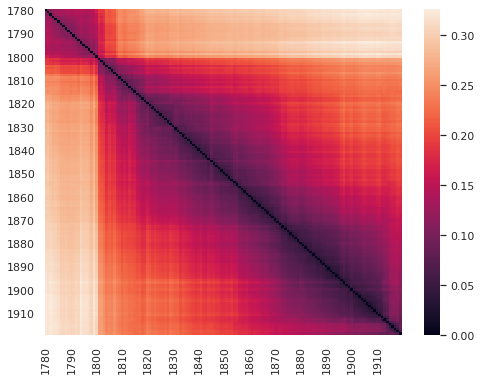

In [19]:
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(df_pairdist,
            xticklabels=10, 
            yticklabels=10)

In [ ]:
selected_years = [5,35,70,100]

df_temp = pd.DataFrame([pairdist[i] for i in selected_years],
                       index=[ts[i] for i in selected_years],
                       columns=ts).T

sns.set(rc={'figure.figsize':(9,5)})
df_temp.plot()

In [ ]:
distances = [1,5,10]

df_dist = pd.DataFrame([[pairdist[i,i+d] for i in range(len(pairdist)-distances[-1])] for d in distances],
             index=distances,
                       columns=ts[distances[-1]:]).T
sns.set(rc={'figure.figsize':(9,5)})
df_dist.plot()

# Word contributions by decade

In [ ]:
# TO DO: Apapt to new code

In [ ]:
matrix = np.squeeze([counts[y] for y in sorted(counts.keys())])

In [ ]:
from collections import defaultdict
dec2idx = defaultdict(list)

for i,y in enumerate(range(1780,1920)):
    dec2idx[int(str(y)[:3]+'0')].append(i)

In [ ]:
dec2idx

In [ ]:
partial_kl = lambda p,q : p * np.log(2 * p / (p + q))       

def partial_js(p,q):
    m = (p + q) / 2
    r = p / m
    if r and r != 2.0:
        return m * ( r * np.log2(r) + (2-r) * np.log2(2-r)) / 2
    return m * ((2) * np.log2(2)) / 2

In [ ]:
counts_by_decade = {}
for decade,idx in dec2idx.items():
    ts_counts = matrix[idx].sum(axis=0)
    ts_total = ts_counts.sum()
    counts_by_decade[decade] = (ts_counts / ts_total)

In [ ]:
matrix_decade = np.squeeze([counts_by_decade[y] for y in sorted(counts_by_decade.keys())])

In [ ]:
labels_decade = sorted(counts_by_decade.keys())
pairdist_decade = pairwise_distances(matrix_decade,metric=jensenshannon)
df_pairdist_decade = pd.DataFrame(pairdist_decade,columns=labels_decade,index=labels_decade)

In [ ]:
#df_pairdist_decade.mean().plot()

In [ ]:
sns.set(rc={'figure.figsize':(7,5)})
sns.heatmap(df_pairdist_decade,
            xticklabels=1, 
            yticklabels=1)

In [ ]:
decades = sorted(counts_by_dec.keys())
indices = range(len(counts_by_dec))
dec_bigrams = list(zip(decades[:-1],decades[1:]))
idx_bigrams = list(zip(indices[:-1],indices[1:]));idx_bigrams

In [ ]:
#corpus.vocab_mapping

In [ ]:

results_part = {}
for d1,d2 in tqdm_notebook(idx_bigrams): # compute feature that have string signal for d2
    results_part[(decades[d1],decades[d2])] = {w : partial_js(matrix_decade[d2,i],matrix_decade[d1,i]) for w,i in corpus.vocab_mapping.items()
                                if not np.isnan(partial_js(matrix_decade[d2,i],matrix_decade[d1,i])) and len(w)>2
                       }

In [ ]:
df_contr_contr = pd.DataFrame(
                sorted(results_part[(1900,1910)].items(),key = lambda x : x[1], reverse=True)[:50],
                columns=['w','c'])
sns.set(rc={'figure.figsize':(5,15)})
sns.barplot(y='w',x='c',data=df_contr_contr,color='b')

# Fin.

## Experiments with lexical coarse-graining

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
from gensim.models import FastText
from sklearn.cluster import KMeans

In [ ]:
model = FastText.load('../fasttext/ft_1760_1900/fasttext_words.model')

In [ ]:
corpus = Corpus('../sparse_ngrams/')
X = [model.wv[w] for w in tqdm_notebook(corpus.vocab_mapping.keys())]

In [ ]:
%time cluster = KMeans(n_clusters=1000, random_state=0).fit(X)

In [ ]:
cluster.labels_[:10]

In [ ]:

matrix_by_cluster = np.matrix(
                    [matrix_norm[:,np.where(cluster.labels_==i)[0]].sum(axis=1) 
                         for i in set(cluster.labels_)]).T

In [ ]:
matrix_by_cluster.shape

In [ ]:
pairdist_cl = pairwise_distances(matrix_by_cluster,metric=jensenshannon)

In [ ]:
labels = sorted(counts_norm.keys())
df_pairdist_cl = pd.DataFrame(pairdist_cl,columns=labels,index=labels)

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(df_pairdist_cl,
            xticklabels=5, 
            yticklabels=5)

## Experiments with temporal fine-graining

In [ ]:
corpus = Corpus('../sparse_ngrams/',n_cores=3)
%time timeseries = corpus.entropy_timeseries(6)

In [ ]:
#import pickle
#with open('../timeseries.pckl','wb') as out_pickle:
#   pickle.dump(timeseries,out_pickle)

In [ ]:
import pickle
with open('../timeseries.pckl','rb') as in_pickle:
    timeseries = pickle.load(in_pickle)

In [ ]:
len(timeseries)

In [ ]:
import pandas as pd
ts = [l for l in timeseries if isinstance(l,pd.core.frame.DataFrame)]

In [ ]:
#ts[:3]

In [ ]:
df_ts = pd.concat(ts)
df_ts.head()

In [ ]:
#df_ts.to_csv('../timeseries.csv')

In [ ]:
df_ts = df_ts.sample(frac=.5)

In [ ]:
df_ts.shape

In [ ]:
#df = pd.concat(timeseries)

In [ ]:
timeseries[0].sum(axis=1)

In [ ]:
newspaper = Newspaper.load(Path('../sparse_ngrams/'),'0000053')

In [ ]:
type(np.zeros((3,4)))

In [ ]:
##newspaper.

In [ ]:
m = newspaper.entropy_timeseries(6)

In [ ]:
m.head()

In [ ]:
nd = np.asarray(m)
nd.shape

In [ ]:
nd[3]

In [ ]:
norm = (newspaper.counts.T / np.squeeze(np.asarray(newspaper.counts.sum(axis=1)))).T

In [ ]:
np.squeeze(np.asarray(norm[1])).shape

In [ ]:
jensenshannon(np.squeeze(np.asarray(norm[1])),np.squeeze(np.asarray(norm[2])))

In [ ]:
norm.shape

In [ ]:
norm.sum(axis=0)

In [ ]:
np.zeros((4,10)).sum(axis=1).shape

In [ ]:
s = np.zeros((0,10),dtype=np.int32)
from scipy.sparse import csr_matrix
sp = csr_matrix(s)
sp

In [ ]:
s = np.zeros((0,10))
np.concatenate([s,np.zeros((2,10))])

In [ ]:
newspaper.metadata

In [ ]:
!ls ../sparse_ngrams/

In [ ]:
corpus = Corpus('../sparse_ngrams/')

In [ ]:
%time monthly_counts,ts_month = corpus.counts_by_timestep('month')

In [ ]:
wf = corpus.plot_vocab_distribution((0,100))

In [ ]:
t = np.sum(list(wf.values()))
wf_norm = pd.Series({w: f/t for w,f in wf.items()})

In [ ]:
sum(pd.Series(wf_norm) >= 1e-8)

In [ ]:
(len(wf_norm) - sum(pd.Series(wf_norm) >= 5e-9)) / len(wf_norm)

In [ ]:
sum(pd.Series(wf_norm) < 0.01) / len(wf_norm)

In [ ]:
counts = corpus.filter_counts(min_freq = 5e-9, max_freq=0.01)

In [ ]:
counts.shape

In [ ]:
#corpus._filter_vocab(1e-8,0.01)

In [ ]:
print(len(corpus.vocab_mapping))

In [ ]:
%time monthly_counts,ts_month = corpus.counts_by_timestep('month')

In [ ]:
#monthly_counts,ts_month = monthly_counts

In [ ]:
#monthly_counts_norm = {k : v/v.sum() for k,v  in sorted(monthly_counts.items())}

In [ ]:
#matrix_monthly_norm = np.squeeze([monthly_counts_norm[y] for y in sorted(monthly_counts_norm.keys())])

In [ ]:
matrix_monthly_norm = (monthly_counts.T / monthly_counts.sum(axis=1)).T

In [ ]:
matrix_monthly_norm.shape

In [ ]:
from scipy.spatial.distance import jensenshannon

def novelty(idx,matrix,window):
    entropies = [jensenshannon(matrix[idx],matrix[idx-i]) for i in range(1,window+1)]
    novelty_score = sum(entropies)/len(entropies)
    return novelty_score

def transience(idx,matrix,window):
    entropies = [jensenshannon(matrix[idx],matrix[idx+i]) for i in range(1,window+1)]
    transcience_score = sum(entropies)/len(entropies)
    return transcience_score

resonance = lambda idx,matrix,window: novelty(idx,matrix,window) - transience(idx,matrix,window)

In [ ]:
window = 3
data1 = [(ts_month[j],
         novelty(j,matrix_monthly_norm,window),
         transience(j,matrix_monthly_norm,window))
                  for j in tqdm_notebook(range(window,len(ts_month) - window))]

In [ ]:
df_ts = pd.DataFrame(data1, columns=['timestamp','novelty','transience'])
df_ts.set_index('timestamp',inplace=True)
df_ts['resonance'] = df_ts.novelty - df_ts.transience

In [ ]:
df_ts.novelty.plot(figsize=(15,5))

In [ ]:
#df_ts['novelty'].diff().sort_values(ascending=False)[:10]
novelty_detrend = (df_ts['novelty'] - df_ts['novelty'].rolling(12).mean())
novelty_detrend.plot(figsize=(15,5))
novelty_detrend.sort_values(ascending=False)[:10]

In [ ]:
sns.scatterplot(x=df_ts['novelty'],y=df_ts['transience'])
sns.regplot(x=df_ts['novelty'],y=df_ts['transience'],color='red',scatter=False)

In [ ]:
novelty_detrend = (df_ts['novelty'] - df_ts['novelty'].rolling(12).mean())
transience_detrend = (df_ts['transience'] - df_ts['transience'].rolling(12).mean())
sns.scatterplot(x=novelty_detrend,y=transience_detrend)
sns.regplot(x=novelty_detrend,y=transience_detrend,color='red',scatter=False)


In [ ]:
df_ts['resonance'].plot(figsize=(15,5))

In [ ]:
df_ts['resonance'].sort_values(ascending=False)[:10]

In [ ]:
def entropy_timeline(idx,matrix,window):
    past_entropies = [jensenshannon(matrix[idx],matrix[idx-i]) for i in range(1,window+1)][::-1]
    future_entropies = [jensenshannon(matrix[idx],matrix[idx+i]) for i in range(1,window+1)]
    entropies = np.array(past_entropies + future_entropies)
    return (entropies - np.mean(entropies)) / np.std(entropies) 

In [ ]:
window = 6
data = [(ts_month[j],
         *entropy_timeline(j,matrix_monthly_norm,window))
                  for j in tqdm_notebook(range(window,len(ts_month) - window))]

In [ ]:
df_ts = pd.DataFrame(data, columns=['timestamp',*range(window*2)])
df_ts.head()

In [ ]:
window=6
from sklearn.cluster import AgglomerativeClustering
X = df_ts.loc[:,[*range(window*2)]].values
model = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
model.fit(X)
labels = model.labels_

In [ ]:
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter

In [ ]:
set(labels)

In [ ]:
import seaborn as sns
sns.set()
label_counts = pd.Series(labels).value_counts()
(label_counts / label_counts.sum()).plot(kind='bar')

In [ ]:
#subset[random_indices]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
bdas = {}
for label in set(labels):
    subset = X[np.where(labels==label)[0]]
    bda = dtw_barycenter_averaging(subset)
    bdas[label] = np.squeeze(bda)
    plt.figure(figsize=(6, 4))
    random_indices = np.random.choice(subset.shape[0], size=250, replace=False)
    for series in subset[random_indices]:
        plt.plot(series, alpha=0.1, color='grey')
    plt.plot(bda, color='red')
    plt.title(f'Cluster {label}')

In [ ]:
pd.DataFrame.from_dict(bdas,orient='index').T.plot(figsize=(15,10))

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [ ]:
df_ts['labels'] = labels

In [ ]:
df_ts['decade'] = df_ts['timestamp'].apply(lambda x: x.split('-')[0][:3])
df_ts['year'] = df_ts['timestamp'].apply(lambda x: int(x.split('-')[0]))

In [ ]:
by_label = df_ts.groupby(['timestamp','labels'])[1].count()

In [ ]:
total = by_label.unstack().sum(axis=1);total

In [ ]:
ef_groups = [7]#[0,5,7]#[6,8,9]#[2,3,4]
series = by_label.unstack().divide(total,axis=0).loc['180':'191',ef_groups].sum(axis=1)
series_df = pd.concat([series,series.rolling(4).mean()], axis=1)
series_df.columns = ['time','rolling']
series_df['time'].plot(alpha=1.,figsize=(25,5))
#series_df['rolling'].plot()

In [ ]:
df_ts['novelty'] = df_ts[range(6)].sum(axis=1)
df_ts['transience'] = df_ts[range(6,12)].sum(axis=1)

In [ ]:
df_ts['resonance'] = df_ts['novelty'] - df_ts['transience']

In [ ]:
df_ts.sort_values('transience',ascending=True)[['timestamp','transience']][:30]

In [ ]:
df_ts[df_ts.labels==9].sort_values('resonance',ascending=False).timestamp[:30]

In [ ]:
df_ts[df_ts.labels==9].timestamp.apply(lambda x: x.split('-')[-1]).value_counts().plot(kind='bar')

In [ ]:
df_ts.iloc[6][2:14].plot()

In [ ]:
from datetime import datetime






for i in range(10):
    time = datetime.now().strftime("%H:%M:%S")
    open('../log.txt','a').write(f'Error {i} with document {time}\n')

In [ ]:
print(open('../log.txt','r').read())

In [ ]:

df_ts[df_ts.year <= 1850][1].plot(kind='density')
df_ts[df_ts.year > 1850][1].plot(kind='density')

In [ ]:
for i in set(labels):
    by_label[:,i].plot()

In [ ]:
df_ts.loc['1850-01':'1850-04']

In [ ]:
sns.scatterplot(x=df_ts['novelty'],y=df_ts['transience'])

In [ ]:
sns.scatterplot(x=df_ts['novelty'].diff(),y=df_ts['transience'].diff())

In [ ]:
sns.scatterplot(x=df_ts['novelty'].diff(),y=df_ts['resonance'].diff())

In [ ]:
df_ts['resonance'].loc['1800-01':].plot()
#df_ts['transience'].loc['1800-01':].plot()

In [ ]:
df_ts['resonance'].loc['1800-01':]

In [ ]:
df_ts['resonance'].loc['1800-01':].diff().sort_values(ascending=False)[:10]

In [ ]:
idx = ts_month.index('1809-02')
contr = {w : partial_js(matrix_monthly_norm[idx,i],
                matrix_monthly_norm[idx-1,i]) for w,i in corpus.vocab_mapping.items()
                                if not np.isnan(partial_js(matrix_monthly_norm[idx,i],
                                                matrix_monthly_norm[idx-1,i])) and len(w)>2}

In [ ]:
sorted(contr.items(),key = lambda x: x[1], reverse=True)[:20]

In [ ]:
df_ts['resonance'].loc['1800-01':].diff().plot()
df_ts['resonance'].loc['1800-01':].plot()

In [ ]:
df_ts.loc['1802-01':].sort_values('resonance',ascending=False)[:20]

In [ ]:
ts_month.index('1846-02')

In [ ]:
print(list(range(-steps,steps+1,1)))

In [ ]:
target_idx = 600


def jump_entropy(target_idx, matrix, window = 1, step_size = 5, steps = 20):
    entropies_by_step = {}
    target =  matrix[target_idx]
    for step in range(-steps,steps+1,1):
        idx = target_idx+(step_size*step)
        print(target_idx,step,idx,idx-window,idx+window)
        segment = matrix[idx-window:idx+window]
        entropies = []
        for r in segment:
            entropies.append(jensenshannon(target,r))
        
        entropies_by_step[step] = sum(entropies)/len(entropies)
    mean = np.mean(list(entropies_by_step.values()))
    std = np.std(list(entropies_by_step.values()))
    entropies_by_step = {k: (v - mean) / std for k,v in entropies_by_step.items()}
    return entropies_by_step

In [ ]:
entropies_by_step = jump_entropy(600, matrix_monthly_norm)

In [ ]:
pd.Series(jump_entropy(600, matrix_monthly_norm)).plot()
#pd.Series(jump_entropy(500, matrix_monthly_norm)).plot()
pd.Series(jump_entropy(793, matrix_monthly_norm)).plot()

In [ ]:
for r in segment:
    entropies.append(jensenshannon(target,r))

# Sparse Matrices without a fixed vocabulary

In [ ]:
path = Path('sparse_matrices/') # Path('sparse_matrices')
sp_f = list(path.glob('*.npz')); len(sp_f)

In [ ]:

nlp_ids = list(set(map(nlp_id,sp_f)))
len(nlp_ids)

In [ ]:
#path = Path('sparse_matrices')
out_path = Path('../ngram-result-sp')
out_path.mkdir(exist_ok=True)

In [ ]:
def get_counts(nlp: str,query_dict: dict) -> pd.DataFrame:
    """
    Given a dictionary that maps as query id to a query (a list of terms)
    terms, this function will compute the absolute frequency counts
    for each of these queries by row (i.e. month). 
    It also computes the total number of tokens by month.
    
    This functions processes a newspaper given an NLP id. 
    It opens a sparse matrix and column (vocab) and row 
    information (metadata). 
    
    Data is safe in the metadata dataframe. The script
    adds a column with total counts and a seperate column
    for each query id in the format 'counts_{query_id}'
    
    Arguments:
        nlp (str):
        query_dict (dict):
    Returns:
        metadata (pd.DataFrame)
    """
    X = load_npz(path / f'{nlp}_sparse_matrix.npz')
    vocab = json.load(open(path / f'{nlp}_sparse_matrix_columns.json','r'))
    vocab_set = set(vocab) 
    metadata = pd.read_csv(path / f'{nlp}_metadata.csv',index_col=0)
    
    for query_id, query in query_dict.items():
        query = [q for q in query if q in vocab_set] # discard query terms that don't appear in vocab
        if query: # if at least one query term appears, get the counts
            query_idx = [vocab.index(q) for q in query]
            metadata[f'counts_{query_id}'] = np.squeeze(np.asarray(X[:,query_idx].sum(axis=1)))
        else: # if none of the query terms appear add a column with zero counts
            metadata[f'counts_{query_id}'] = np.array([0] * X.shape[0])
    
    metadata['totals'] = np.squeeze(np.asarray(X.sum(axis=1))) 
    return metadata



def get_timeseries(query_dict: dict,time_step: str='year_month') -> pd.DataFrame:
    """
    Arguments:
        query_dict (dict):
        time_step (str):
    
    Returns:
        pd.DataFrame
    """
    
    input_variables = [[idx,query_dict] for idx in nlp_ids]
    with multiprocessing.Pool(6) as pool: 
        results = pool.starmap(get_counts,input_variables)
    
    df = pd.concat(results,axis=0)
    
    if time_step == 'year_month':
        df['year_month'] = df.month.apply(lambda x: datetime.strptime(x, "%Y-%m").date())
        df['year_month'] = pd.to_datetime(df['year_month'])
    elif time_step == 'decade':
        df['decade'] = df.year.apply(lambda x: int(str(x)[:3]+'0'))
                                     
    by_time_step = df.groupby(time_step)[
                        [f'counts_{q_idx}' for q_idx in query_dict.keys()] +['totals']
                            ].sum().reset_index()

    by_time_step = by_time_step.set_index(time_step)
    
    by_time_step[
        [f'ratio_{q_idx}' for q_idx in query_dict.keys()]
                    ] = by_time_step[
                            [f'counts_{q_idx}' for q_idx in query_dict.keys()]
                                        ].divide(by_time_step['totals'],axis=0)

    return by_time_step

In [ ]:
%%time
query_dict = {1:['machine'],
              2:['train','railway'],
              3:['accident','accidents'],
              4:['machine','machines'],5:['snow','freezing','frost']}

df = get_timeseries(query_dict)

In [ ]:
df.shape

In [ ]:
q_idx = 5
df.loc[datetime.strptime('1780-01',"%Y-%m").date() : datetime.strptime('1920-01',"%Y-%m").date(),f'ratio_{q_idx}'
              ].plot(figsize=(16,6),  alpha=.75)

In [ ]:
(df.resample('Y')[f'counts_{q_idx}'].sum() / df.resample('Y')['totals'].sum())['1780':'1920'].plot()


# Cyclical Effects

In [ ]:

df['month'] = df.apply(lambda x: x.name.month,axis=1)
df["month_id"] = df['month'] - 1


In [ ]:
# more accidents in winter month pre-1840
start_year, end_year = 1800,1840# 
q_idx = 3

In [ ]:
# https://towardsdatascience.com/time-series-analysis-with-theory-plots-and-code-part-1-dd3ea417d8c4


sns.boxplot(df.loc[datetime.strptime(f'{start_year}-01',"%Y-%m").date(): datetime.strptime(f'{end_year}-01',"%Y-%m").date()]['month'],
            df.loc[datetime.strptime(f'{start_year}-01',"%Y-%m").date(): datetime.strptime(f'{end_year}-01',"%Y-%m").date()][f'ratio_{q_idx}'])

In [ ]:
df_sel = df.loc[
    datetime.strptime(f'{start_year}-01',"%Y-%m").date(): datetime.strptime(f'{end_year}-01',"%Y-%m"
                                                                           ).date()
                        ]

In [ ]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series
df_sel['ratio_std'] = standardize(df_sel[f'ratio_{q_idx}'])
df_sel['ratio_std'].plot(kind='density')

In [ ]:
with pm.Model() as m1:
    sigma = pm.Exponential('sigma',1)
    mu = pm.Normal('mu',0,0.5,shape=df_sel["month_id"].max()+1)
    prob = pm.Normal('prob',mu=mu[df_sel["month_id"]], sigma=sigma,observed=df_sel['ratio_std'].values)
    m1_trace = pm.sample()
    
az.summary(m1_trace)

In [ ]:
ax = az.plot_forest(m1_trace,var_names=['mu'],combined=True,hdi_prob=.89,)
ax[0].set_yticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul',"Aug",'Sep','Oct','Nov','Dec'][::-1])